In [1]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots, colors

## colors

In [ ]:
colors_lst, red, cmap = colors.color_scheme()

# Parameters

In [2]:
## Parameters

## task type
task_type='Regression'


# ## task matrix X
# M_values: np.ndarray = array([0.15, 0.2, 0.015, 0.1, 0.01, 0.03, 0.05, 0.12, 0.23, 0.25, 0.12, 0.1, 0.02, 0.3, 0.35, 0.25,
#                               0.03, 0.02, 0.25, 0.31, 0.02, 0.08, 0.35, 0.1, 0.03, 0.2, 0.1, 0.18, 0.12, 0.35, 0.05, 0.15,
#                               0.25, 0.25, 0.02, 0.01, 0.08, 0.07, 0.35, 0.15, 0.01, 0.25, 0.13, 0.05, 0.03, 0.3, 0.32, 0.05,
#                               0.15, 0.12, 0.25, 0.1, 0.25, 0.3, 0.25, 0.25, 0.04, 0.27, 0.1, 0.11, 0.02, 0.2, 0.4, 0.15,
#                               ])

## specify # of nodes
Nin: int = 0
extraNin: int = 0
Ninter: int = 0
Nout: int = 0
extraNout: int = 0

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.])

alpha: float = 0.25  # for network combine attempt
stay_sample: int = 2

# length of training dataset
iterations = int(3e4)  # number of sampled of p

stay_sample = 2

random_state = 42

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
include_Power: bool = False
lam: float = 0
    
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [3]:
def network_build_given_Nin_Nout(Nin: int, Nout: int, M_values: NDArray[np.float_]) -> tuple():
    
    # initialize Variables
    Variabs = User_Variables(iterations,\
                             Nin, \
                             extraNin, \
                             Ninter, \
                             Nout, \
                             extraNout, \
                             gamma, \
                             R_update, \
                             use_p_tag, \
                             include_Power, lam, \
                             supress_prints, \
                             bc_noise, \
                             access_interNodes, \
                             task_type, \
                             measure_accuracy_every)
    
    Variabs.assign_alpha_vec(alpha)
    # normalize Nin*Nout values of M to norm of 0.5
    M_values_norm = normalize([M_values[:Nin*Nout]], norm="l1")[0]/2
    print('M_norm', M_values_norm)
    Variabs.create_dataset_and_targets(random_state, M_values_norm)
    Variabs.create_noise_for_extras()
    BigClass = Big_Class(Variabs)
        
    # initialize Structure
    inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                            Variabs.Nout, Variabs.extraNout)
        
    
    Strctr = Network_Structure(inInterOutGround_tuple)
    Strctr.build_incidence()
    Strctr.build_edges()
    BigClass.add_Strctr(Strctr)  # add to big class
    
    # initialize State    
    State = Network_State(Variabs)
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
    BigClass.add_State(State)  # add to big class
    
    return Variabs, Strctr, State, BigClass


def random_gen_M(random_state: int, size: NDArray[np.int_]) -> NDArray[np.float_]:
    """
    random_gen_M generates a random M_values array for regression task
    use for multiple_Nin_Nout for example, and before train_loop()
    
    inputs:
    random_state - int, random seed
    size         - size of M_values, train_loop then decides how many to take
    """
    # generate random state
    random_gen = np.random.RandomState(random_state_M)

    # Generate random values with the defined random state
    M_values = random_gen.rand(10 * 10)
    
    return M_values


def train_loop(Variabs, Strctr, State, BigClass):
    loss_mean = [1, 1]
    for l in range(Variabs.iterations):
        
        k = (l//stay_sample)*2 + l%2

        # draw input and desired outputs from dataset
        if not((l+1) % 4):  # add noise only at i=3 etc.
            State.draw_p_in_and_desired(Variabs, k, noise_to_extra=False)  # add noise to extra nodes every 2nd iteration
            State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)  # measure and don't change resistances
        else:  # dont add noise to extra nodes
            State.draw_p_in_and_desired(Variabs, k)
            State.solve_flow_given_problem(BigClass, "measure")

        if not l % 2:  # even iterations, take another sampled pressure and measure again
            pass
        else:  # odd iterations, go to dual problem and update resistances
            State.t += 1
            State.calc_loss(BigClass)
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
            State.update_Rs(BigClass)
            
        if not (l+1)%window_for_mean:
            # print('l', l)
            loss_mean.append(np.mean(np.mean(np.abs(State.loss_in_t[-window_for_mean:]), axis=1)))
            # print(loss_mean)
            
        if loss_mean[-1]<10e-8 or (loss_mean[-1]-loss_mean[-2])>0 or loss_mean[-1]>2:
            break
            
    return State

# Loop

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


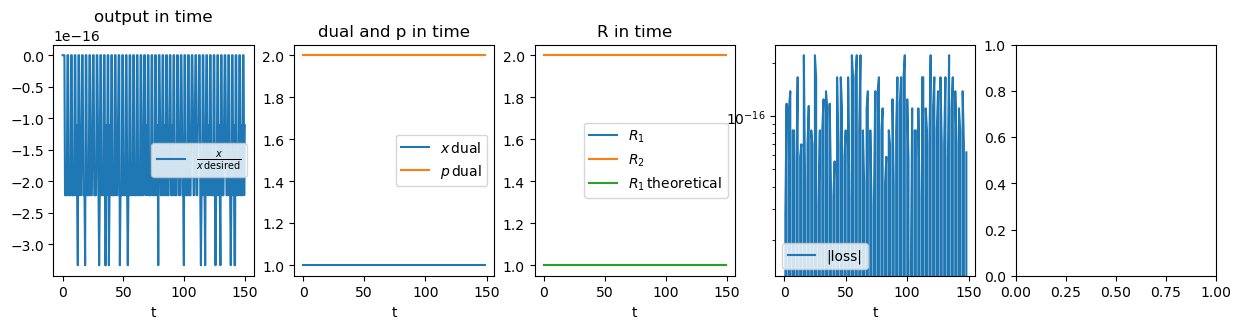

Nin 1
Nout 2
M_norm [0.14130876 0.35869124]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1689964052404007
no NET assigned in input


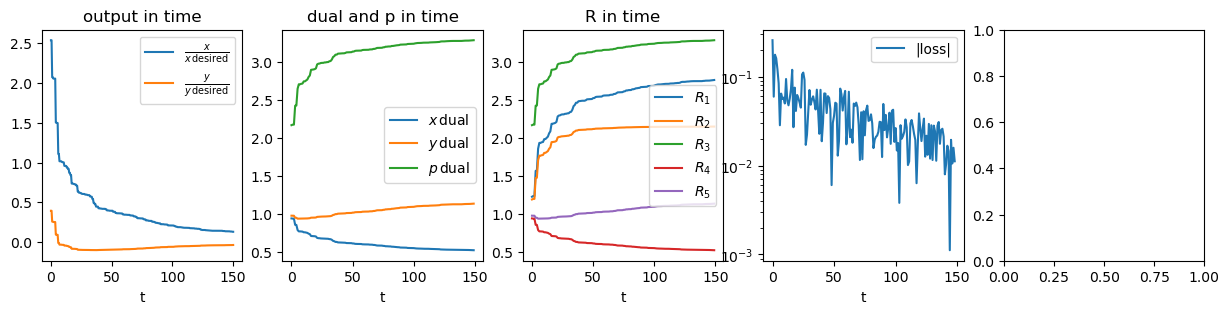

Nin 2
Nout 1
M_norm [0.14130876 0.35869124]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07303924235291563
no NET assigned in input


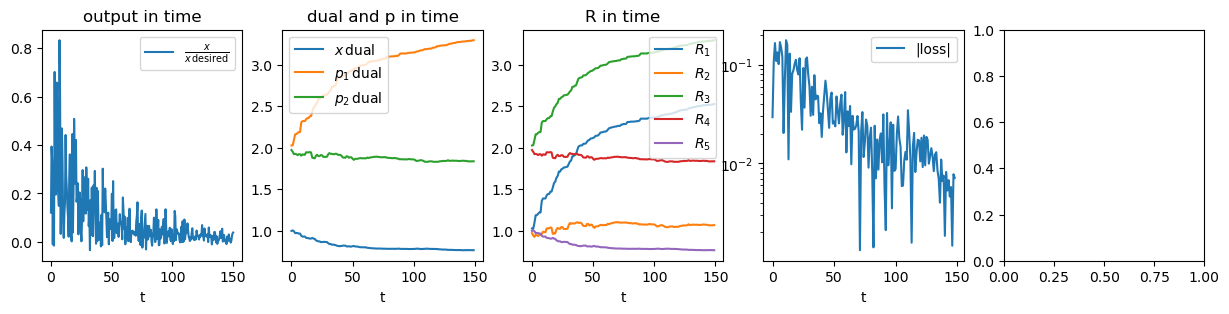

Nin 2
Nout 2
M_norm [0.07051078 0.17898111 0.1378049  0.11270322]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.3401269996343755
no NET assigned in input


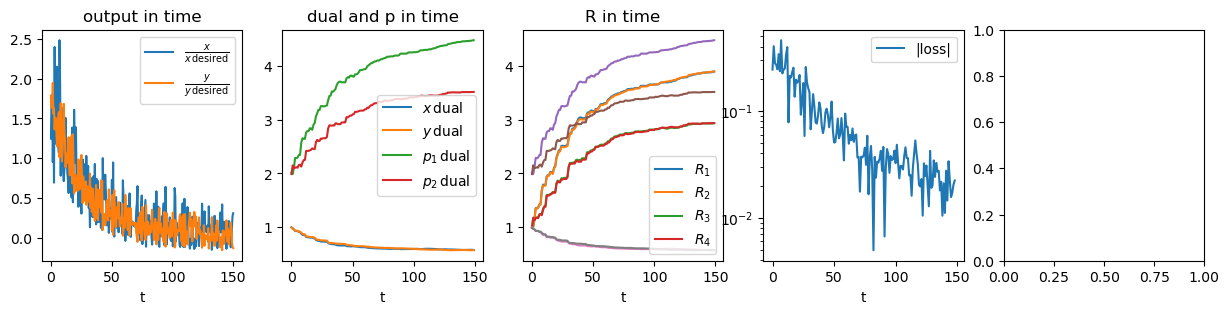

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


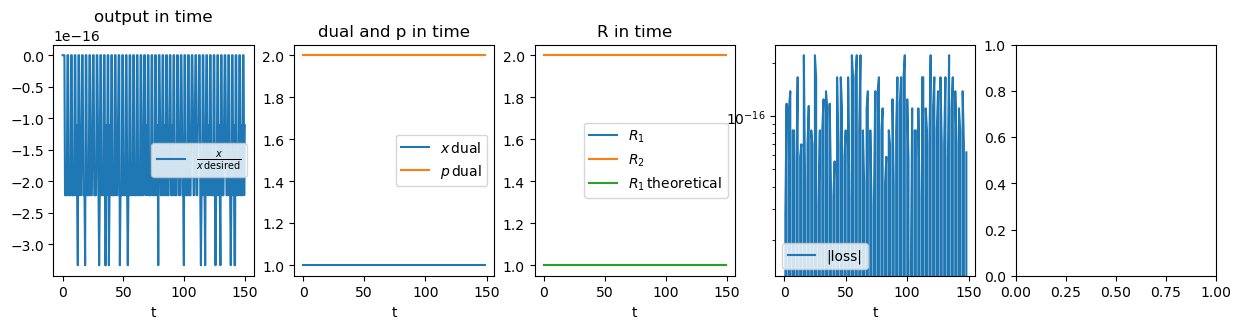

Nin 1
Nout 2
M_norm [0.07944428 0.42055572]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.2597845600679578
no NET assigned in input


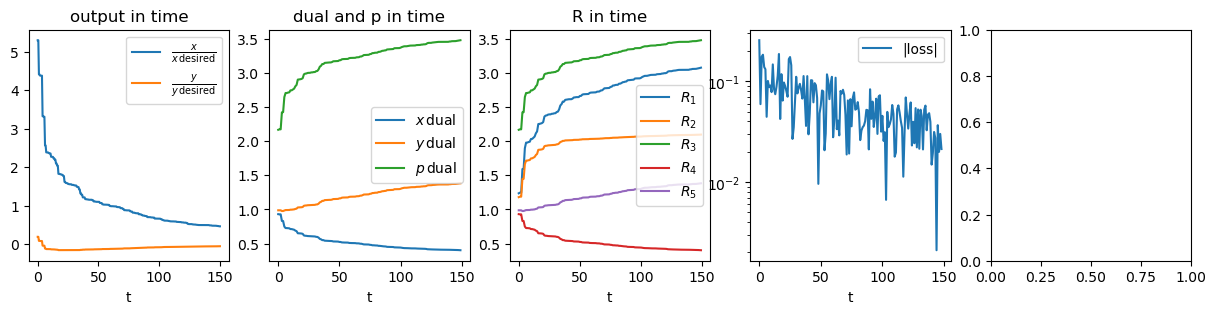

Nin 2
Nout 1
M_norm [0.07944428 0.42055572]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.11149332613643725
no NET assigned in input


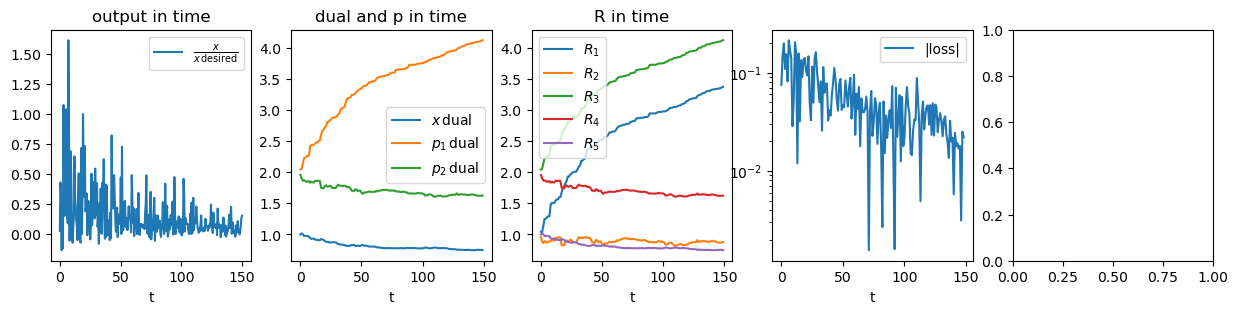

Nin 2
Nout 2
M_norm [0.05238794 0.27732702 0.06073707 0.10954797]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.38243921231805805
no NET assigned in input


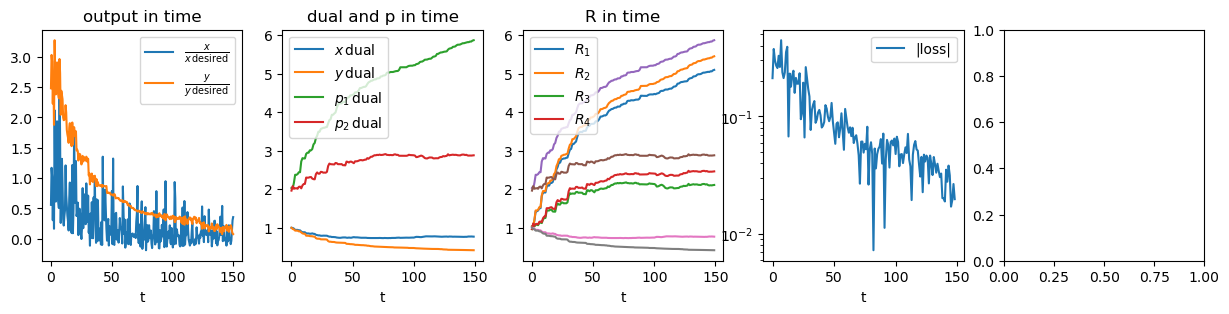

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


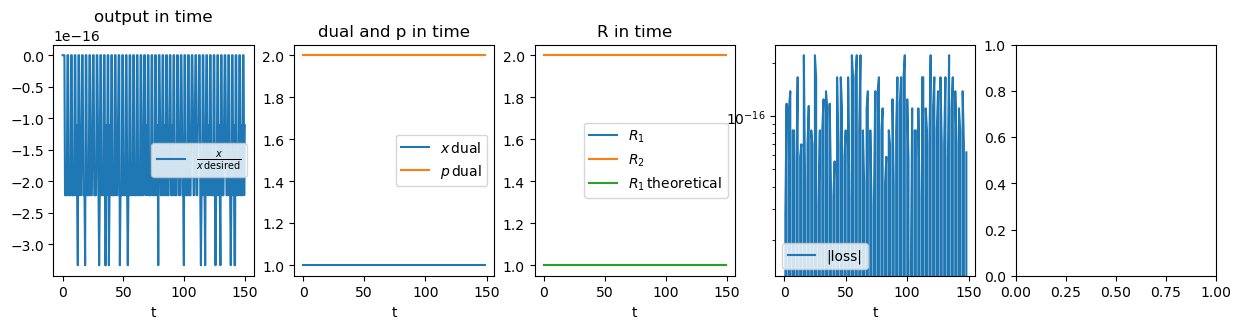

Nin 1
Nout 2
M_norm [0.44423593 0.05576407]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.2983514565511394
no NET assigned in input


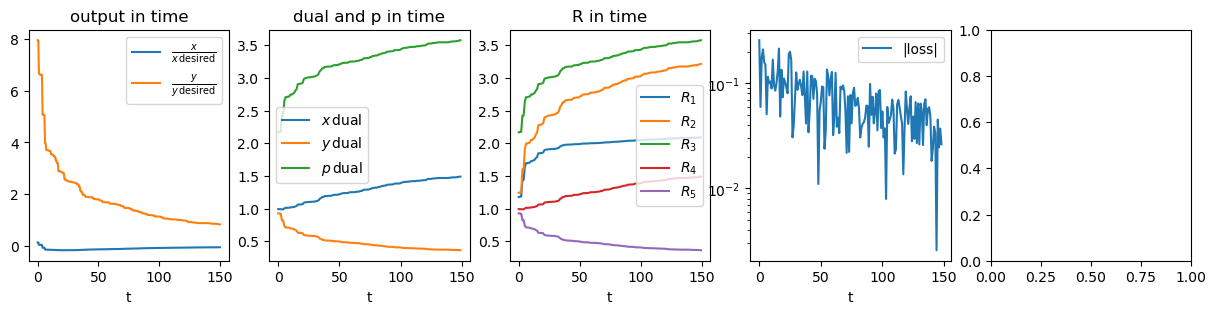

Nin 2
Nout 1
M_norm [0.44423593 0.05576407]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.17801305715108254
no NET assigned in input


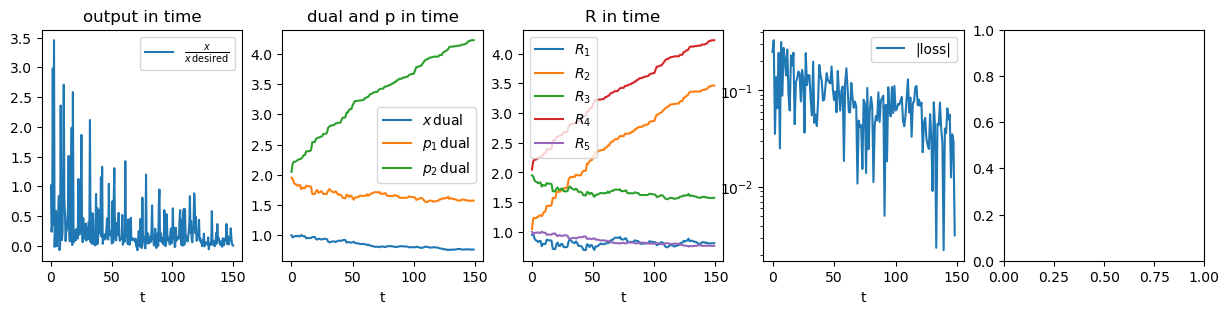

Nin 2
Nout 2
M_norm [0.20413989 0.02562528 0.18208331 0.08815152]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.39055700907242297
no NET assigned in input


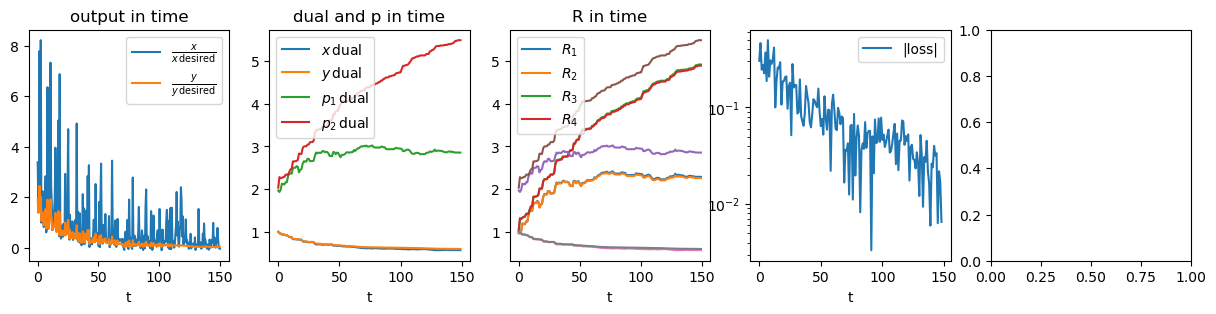

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


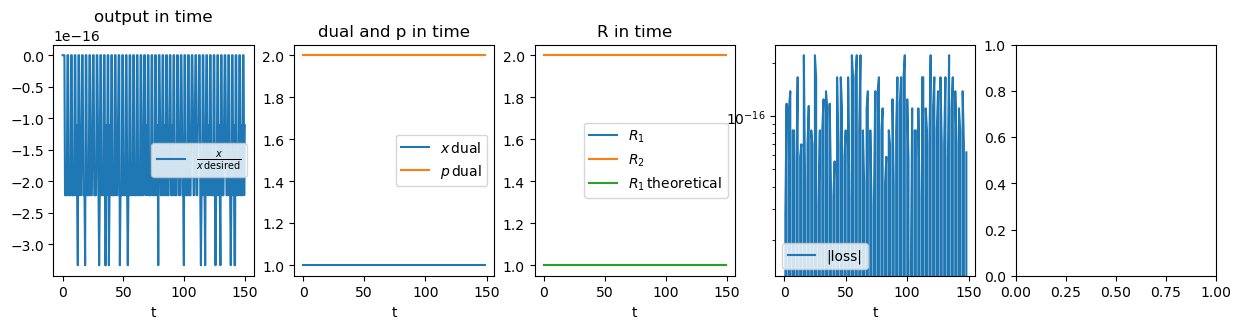

Nin 1
Nout 2
M_norm [0.32140896 0.17859104]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12184978150464945
no NET assigned in input


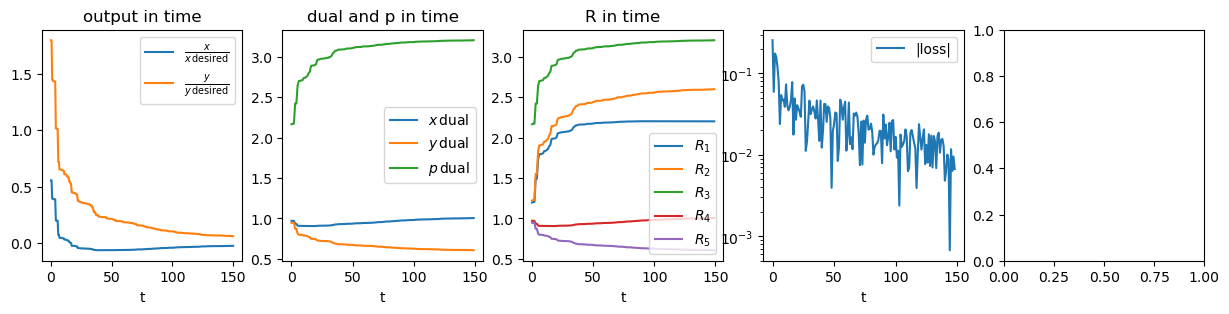

Nin 2
Nout 1
M_norm [0.32140896 0.17859104]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08522114938457197
no NET assigned in input


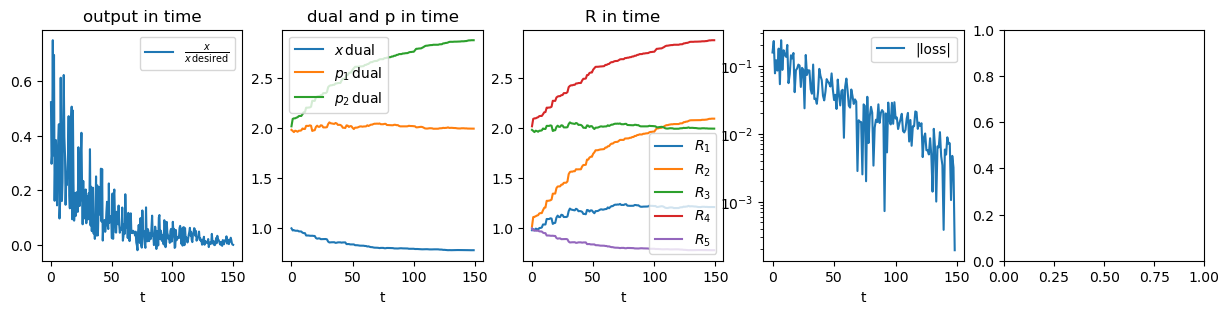

Nin 2
Nout 2
M_norm [0.26063751 0.14482336 0.07417075 0.02036838]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.41866460441340336
no NET assigned in input


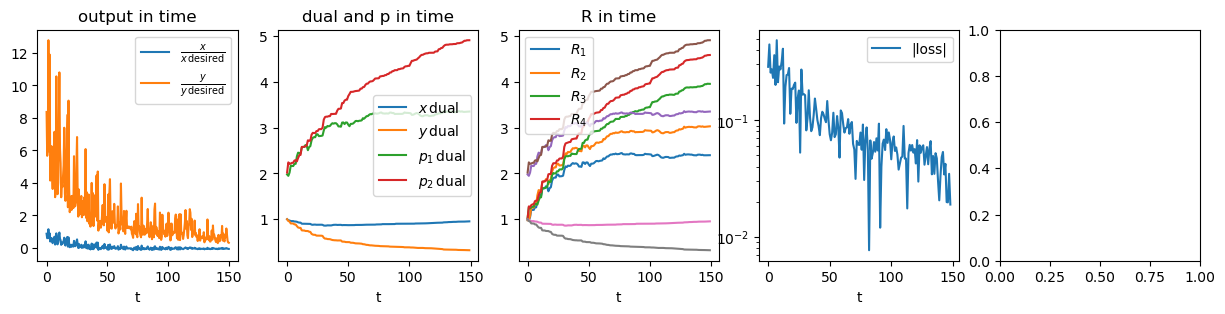

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


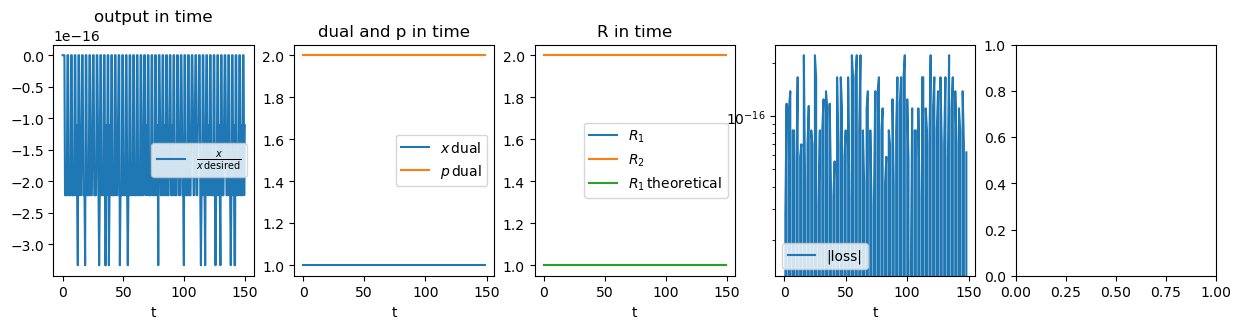

Nin 1
Nout 2
M_norm [0.27625682 0.22374318]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07714979774373934
no NET assigned in input


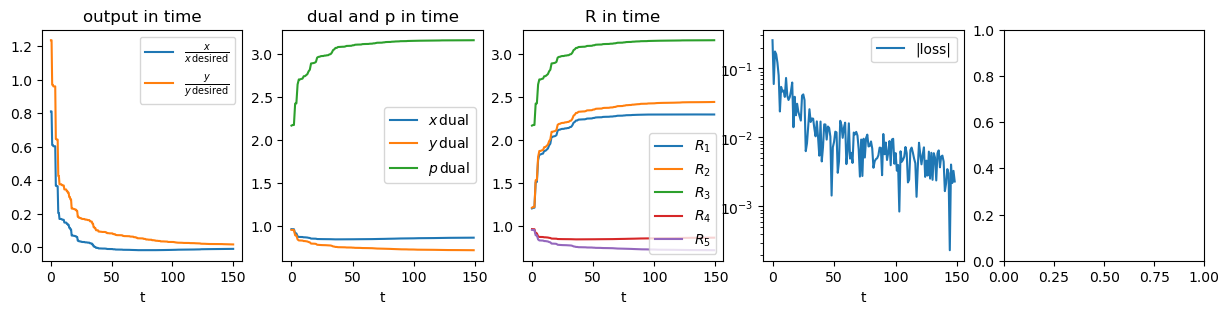

Nin 2
Nout 1
M_norm [0.27625682 0.22374318]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06759725473514301
no NET assigned in input


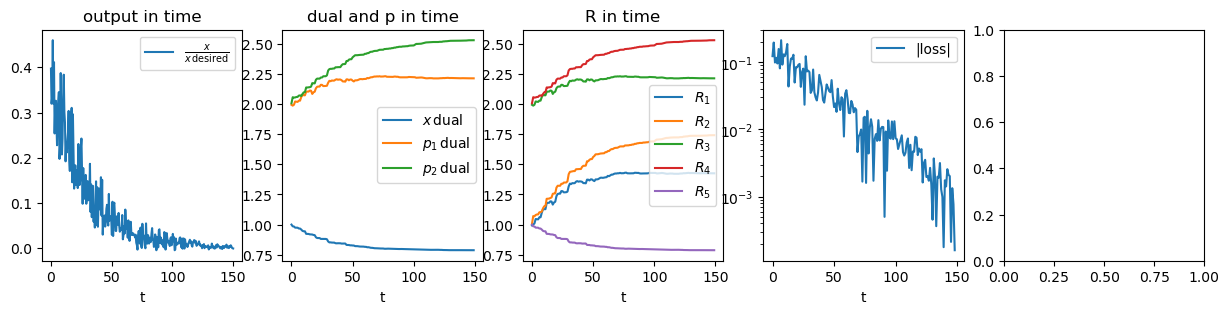

Nin 2
Nout 2
M_norm [0.16156262 0.13085119 0.05133247 0.15625372]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.34664692263203273
no NET assigned in input


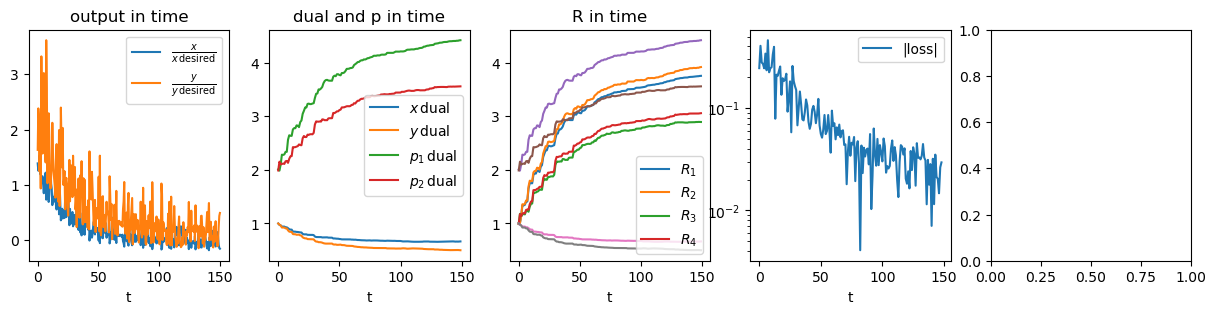

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


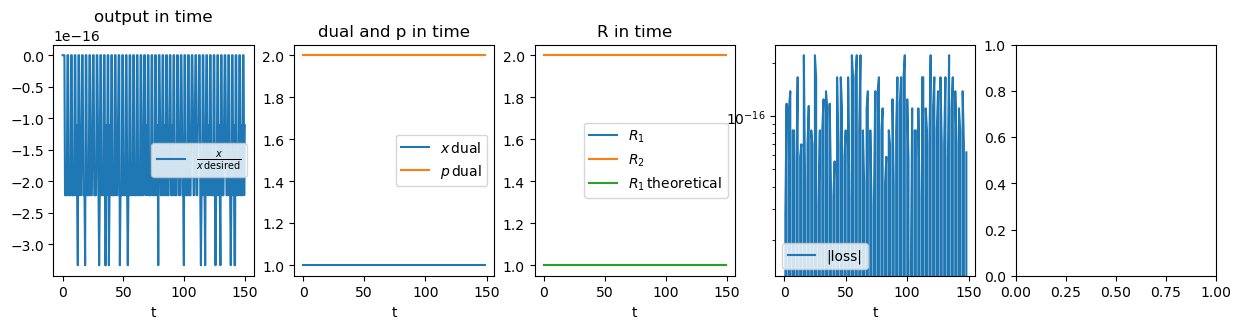

Nin 1
Nout 2
M_norm [0.05215599 0.44784401]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.3043887826967858
no NET assigned in input


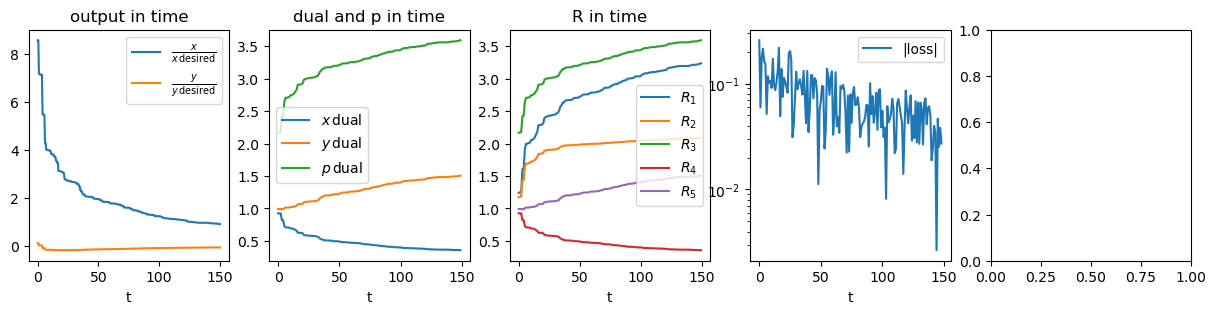

Nin 2
Nout 1
M_norm [0.05215599 0.44784401]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1345379085200337
no NET assigned in input


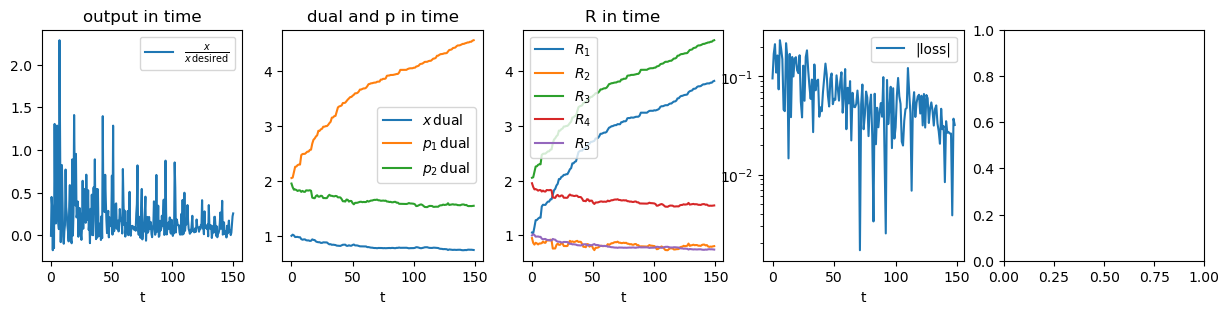

Nin 2
Nout 2
M_norm [0.02617144 0.22472437 0.16805262 0.08105157]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.3942915977816804
no NET assigned in input


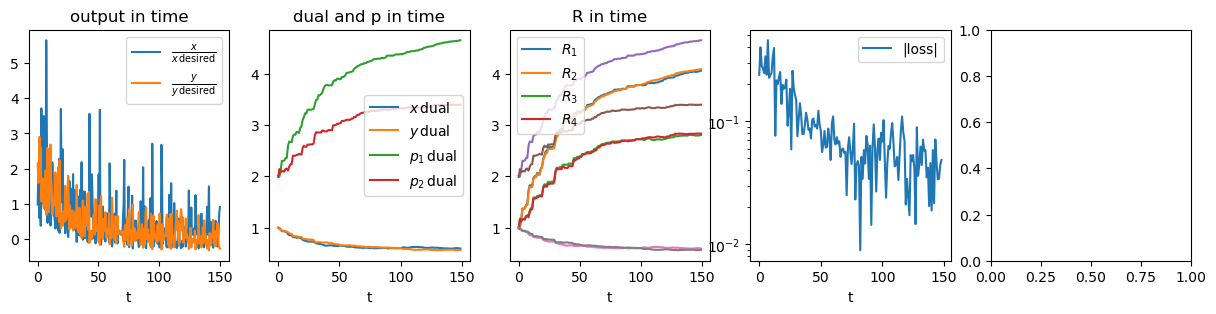

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


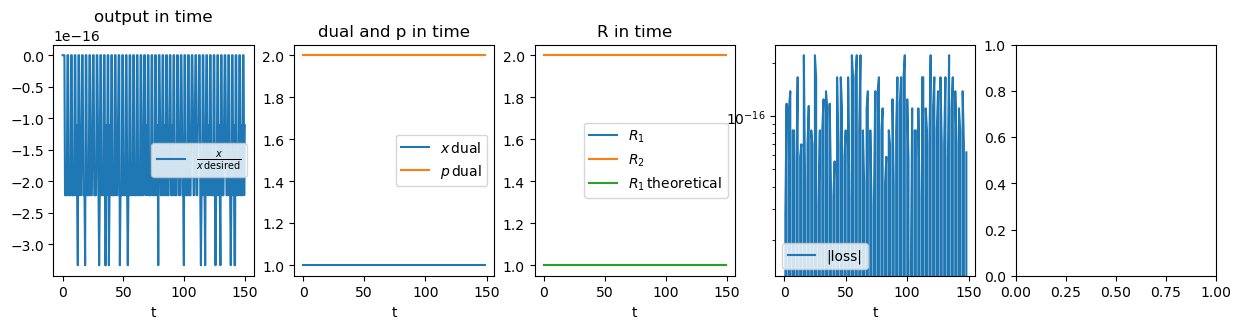

Nin 1
Nout 2
M_norm [0.00961994 0.49038006]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.3809554717312227
no NET assigned in input


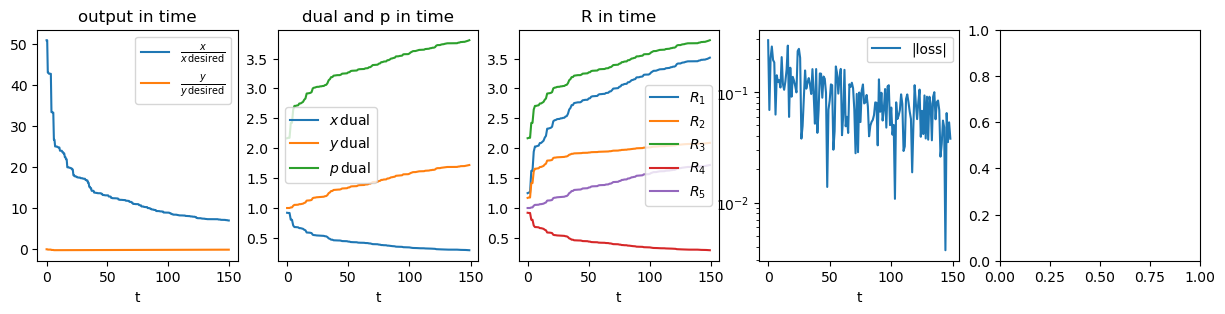

Nin 2
Nout 1
M_norm [0.00961994 0.49038006]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.17661123366724168
no NET assigned in input


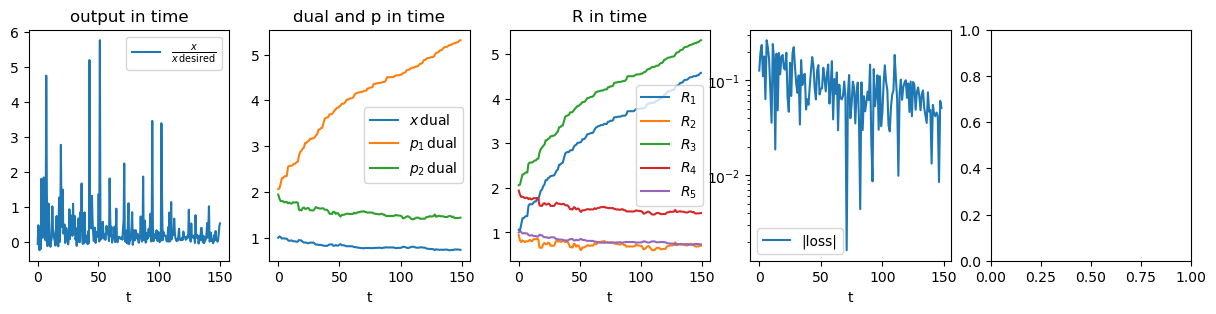

Nin 2
Nout 2
M_norm [0.00585781 0.29860427 0.09540524 0.10013268]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.40682939765195714
no NET assigned in input


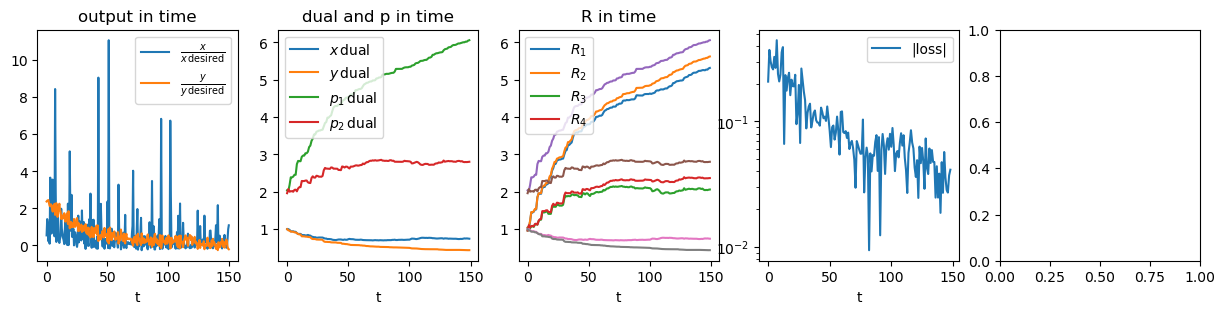

Nin 1
Nout 1
M_norm [0.5]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.455164457761264e-16
no NET assigned in input


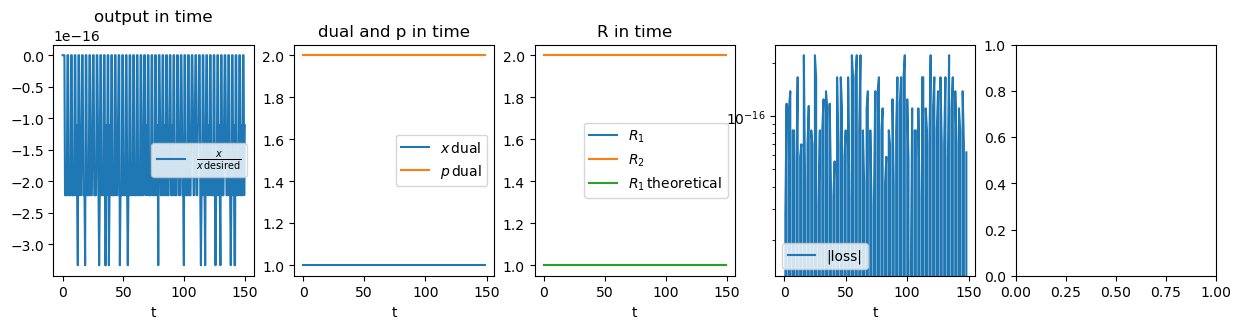

Nin 1
Nout 2
M_norm [0.27458943 0.22541057]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07583135311959358
no NET assigned in input


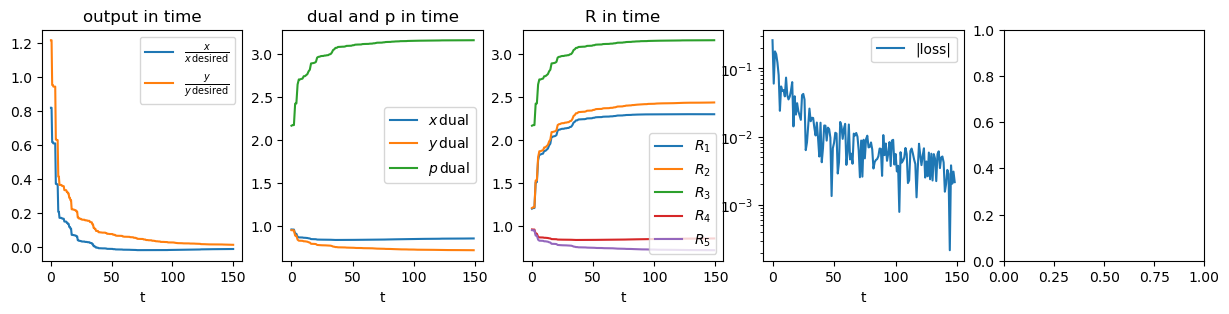

Nin 2
Nout 1
M_norm [0.27458943 0.22541057]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06711870906354232
no NET assigned in input


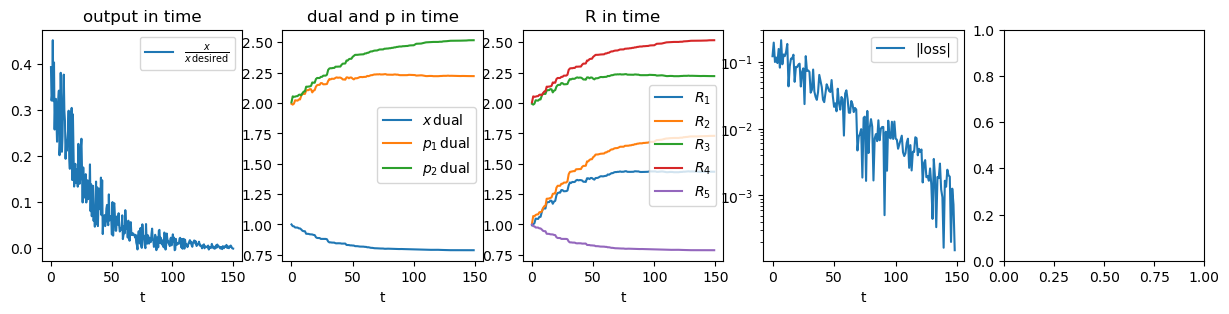

Nin 2
Nout 2
M_norm [0.0636029  0.05221164 0.19576266 0.1884228 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.3900243563364344
no NET assigned in input


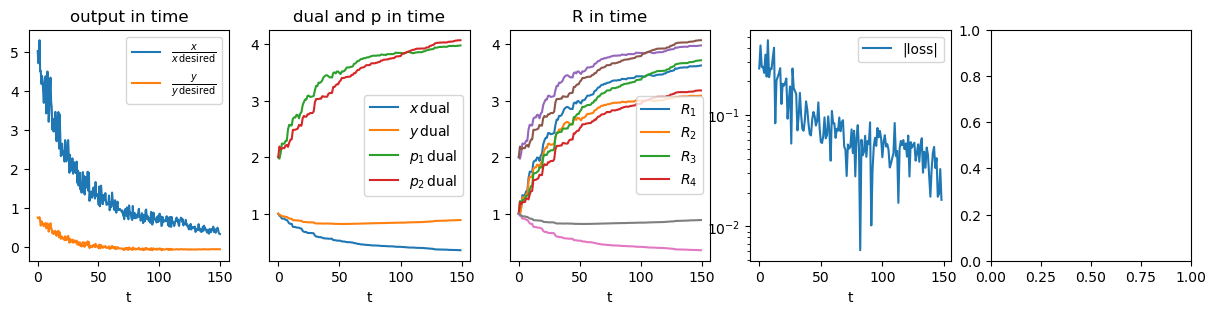

In [4]:
window_for_mean = 1000
n = 10
random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])

for k, random_state_M in enumerate(random_state_M_vec):
    M_values = random_gen_M(random_state_M, n*n)
    for i in range(n):
        for j in range(n):
            Nin: int = i + 1
            Nout: int = j + 1
            print('Nin', Nin)
            print('Nout', Nout)

            Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
            State = train_loop(Variabs, Strctr, State, BigClass)

            mean_loss_ij = np.mean(np.mean(np.abs(State.loss_in_t[-window_for_mean:]), axis=1))
            norm_mean_loss_ij = mean_loss_ij / np.mean(Variabs.targets)
            print('norm_mean_loss_ij', norm_mean_loss_ij)

            norm_mean_loss[i, j, k] = norm_mean_loss_ij
            plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

In [5]:
Variabs.targets

array([[0.14692039, 0.50491444],
       [0.15562776, 0.51219597],
       [0.03613594, 0.1198711 ],
       [0.09783753, 0.34915587],
       [0.15040458, 0.50218578],
       [0.10389964, 0.37356561],
       [0.12806468, 0.40594143],
       [0.04228089, 0.14030426],
       [0.09349817, 0.31687069],
       [0.08535702, 0.27886583],
       [0.09239765, 0.29212354],
       [0.0754192 , 0.25244387],
       [0.1400054 , 0.47445305],
       [0.07909771, 0.27196432],
       [0.08020907, 0.24944993],
       [0.09508992, 0.30213045],
       [0.10736069, 0.38305268],
       [0.20724951, 0.68271037],
       [0.04894788, 0.15607131],
       [0.13300058, 0.43376408],
       [0.06723197, 0.2343863 ],
       [0.09932865, 0.35613737],
       [0.10210107, 0.35098752],
       [0.09395867, 0.31802812],
       [0.08884783, 0.2837125 ],
       [0.20427871, 0.67172232],
       [0.21295053, 0.70504936],
       [0.17232149, 0.58149722],
       [0.03172193, 0.10850233],
       [0.03972524, 0.14030693],
       [0.

In [6]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'

np.save(save_folder_prelim + 'loss_mat.npy', norm_mean_loss)

In [12]:
np.mean(norm_mean_loss, axis=2)

array([[1.45516446e-16, 2.10913451e-01],
       [1.11703985e-01, 3.83697512e-01]])

In [7]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(norm_mean_loss, )

TypeError: loss_afo_in_out() missing 1 required positional argument: 'cmap'

In [ ]:
alpha=0.1

Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(6, 10)
State = train_loop(Variabs, Strctr, State, BigClass)

mean_loss_ij = np.mean(np.mean(np.abs(State.loss_in_t[-window_for_mean:]), axis=1))
norm_mean_loss_ij = mean_loss_ij / np.mean(Variabs.targets)
print('norm_mean_loss_ij', norm_mean_loss_ij)